# TP3: Análisis de datos RRBS (*Reduced Representation Bisulfite Sequencing*)


**Nota**: Este cuaderno asume que el [TP0](https://colab.research.google.com/github/VeronicaNoe/EpiEvo/blob/main/cuadernos/TP0_espacio_de_trabajo.ipynb) ha sido completado con éxito.

**Objetivo:** Familiarizarse con la identificación de citosinas metiladas usando datos RRBS de vid [_Vitis vinifera_](https://link.springer.com/article/10.1007/s00299-020-02617-w).


<p align="left">
<img src="https://raw.githubusercontent.com/VeronicaNoe/EpiEvo/main/img/3/TP_3_A.JPG" width="500"/> 
</p>

Fotografía de [Anabella Varela](https://researchgate.net/profile/Anabella-Varela).

# Contenido

0.   [Preparación de cuaderno](#step-0)
1.   [Preparación del espacio de trabajo en R](#step-1)
2.   [Análisis de datos obtenidos por *RRBS*](#step-2)
  1.   [Introducción](#step-2.1)
  2.   [Unir archivos](#step-2.2)
  3.   [Explorar datos](#step-2.3)
  4.   [Control de calidad](#step-2.4)
  5.   [Caracterización global de la metilación](#step-2.5)
  6.   [Citosinas diferencialmente metiladas](#step-2.6)
3.   [OPCIONAL: Guardar en Drive](#step-3)



<a name="step-0"></a>
# Preparación del cuaderno

Un opción útil para el resto de los TPs es la posibilidad de contectar un cuaderno con Google Drive.

Los siguientes pasos muestran como realizar dicha conexión:

1. Presionar el botón play, cliquea el enlace mostrado en `Go to this URL in a browser`.
<img src="https://raw.githubusercontent.com/VeronicaNoe/EpiEvo/main/img/0/00_paso1a.png" width="550"/>

2. Copie el código de autenticación.
<img src="https://raw.githubusercontent.com/VeronicaNoe/EpiEvo/main/img/0/00_paso1b.png" width="550"/>

3. Ingresar dicho código en el campo `Enter authorization code`.
<img src="https://raw.githubusercontent.com/VeronicaNoe/EpiEvo/main/img/0/00_paso1c.png" width="550"/>

In [ ]:
#@title Solicitar acceso a Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Para trabajar de forma ordenada, se crearán 3 carpetas en colab:
- *rawData*: en donde estarán los archivos necesarios para trabajar (**input**)
- *results*: en donde se guardarán los archivos generados (**output**)
- *plots*: en donde se guardarán los pdf de las figuras (**output**)

In [ ]:
#@title Crear directorios de trabajo
%%bash
mkdir {rawData,plots,results}
rm -r sample_data/ # eliminarmos la carpeta que está por default en colab
ls

drive
plots
rawData
results


In [ ]:
#@title Cargar archivos
# Descargar archivos en el directorio
%%bash
cp -r /content/drive/MyDrive/EpiEvo/epievo_data/3/* /content/rawData
ls /content/rawData

Agrelo_10A1_trimmed_bismark_bt2.bismark_covered_only.CHG_report.txt
Agrelo_10A1_trimmed_bismark_bt2.bismark_covered_only.CHH_report.txt
Agrelo_10A1_trimmed_bismark_bt2.bismark_covered_only.CpG_report.txt
Agrelo_10A4_trimmed_bismark_bt2.bismark_covered_only.CHG_report.txt
Agrelo_10A4_trimmed_bismark_bt2.bismark_covered_only.CHH_report.txt
Agrelo_10A4_trimmed_bismark_bt2.bismark_covered_only.CpG_report.txt
Agrelo_10A7_trimmed_bismark_bt2.bismark_covered_only.CHG_report.txt
Agrelo_10A7_trimmed_bismark_bt2.bismark_covered_only.CHH_report.txt
Agrelo_10A7_trimmed_bismark_bt2.bismark_covered_only.CpG_report.txt
annotation.csv
commonFunctions.R
Gualtallary_10G3_trimmed_bismark_bt2.bismark_covered_only.CHG_report.txt
Gualtallary_10G3_trimmed_bismark_bt2.bismark_covered_only.CHH_report.txt
Gualtallary_10G3_trimmed_bismark_bt2.bismark_covered_only.CpG_report.txt
Gualtallary_10G7_trimmed_bismark_bt2.bismark_covered_only.CHG_report.txt
Gualtallary_10G7_trimmed_bismark_bt2.bismark_covered_only.CHH_r

<a name="step-1"></a>
# Preparación del espacio de trabajo en R




In [ ]:
#@title Cargar R
%load_ext rpy2.ipython

## Instalar paquetes, cargar librerías y establecer directorio de trabajo
<font color="red">**NOTA**</font>: En algún punto, le va a solicitar que decida si se actualizan los paquetes. 

Es recomendable que <font color="red">**NO actualice**</font> (opción `n`).

<p align="left">
<img src="https://raw.githubusercontent.com/VeronicaNoe/EpiEvo/main/img/Kahoot_img.png" width="100"/> 
</p>

In [ ]:
#@title Instalar paquetes de CRAN (ejecutar)
%%R
install.packages(c("plyr","reshape2","qqman"), quiet=TRUE)

R[write to console]: also installing the dependency ‘calibrate’




In [ ]:
#@title Instalar paquetes de Bioconductor (ejecutar)
%%R
if (!requireNamespace("BiocManager"))
    install.packages("BiocManager", quiet=TRUE)

BiocManager::install("methylKit", quiet=TRUE)

R[write to console]: Loading required namespace: BiocManager

R[write to console]: Failed with error:  
R[write to console]: 
R[write to console]: ‘there is no package called ‘BiocManager’’
R[write to console]: 
R[write to console]: 

R[write to console]: 'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cran.rstudio.com


R[write to console]: Bioconductor version 3.14 (BiocManager 1.30.16), R 4.1.1 (2021-08-10)

R[write to console]: Installing package(s) 'BiocVersion', 'methylKit'

R[write to console]: also installing the dependencies ‘formatR’, ‘matrixStats’, ‘lambda.r’, ‘futile.options’, ‘MatrixGenerics’, ‘DelayedArray’, ‘numDeriv’, ‘bdsmatrix’, ‘mvtnorm’, ‘futile.logger’, ‘snow’, ‘BH’, ‘SummarizedExperiment’, ‘rjson’, ‘BiocGenerics’, ‘XVector’, ‘RCurl’, ‘GenomeInfoDbData’, ‘coda’, ‘bbmle’, ‘Biostrings’, ‘bitops’, ‘BiocParallel’, ‘Biobase’, ‘XML’, ‘GenomicAlignments’, ‘BiocIO’, ‘restfulr’, ‘

Update all/some/none? [a/s/n]: n


In [ ]:
#@title Cargar todos los paquetes (ejecutar)
%%R
suppressPackageStartupMessages({
  library("plyr") 
  library("reshape2") 
  library("qqman")
  library("methylKit")
  source(file.path("/content/rawData", "commonFunctions.R"))
})

In [ ]:
#@title Definir directorio de trabajo
%%R
setwd("/content/results")
getwd()

[1] "/content/results"


<a name="step-2"></a>
# Análisis de datos obtenidos por *RRBS*

<a name="step-2.1"></a>
## Introducción

Analizaremos la metilación del ADN en `clones` de un genotipo de *Vitis vinifera* cv.  Malbec cultivados en dos viñedos contrastantes: Agrelo **(Agr)** y Gualtallary **(Gua)**. [Varela et al., 2020](https://link.springer.com/article/10.1007/s00299-020-02617-w).

A pesar de que en cada localidad se cultivan clones, genéticamente idénticos, se observan diferencias fenotípicas entre ellos asociados a cada localidad.

La réplicas biológicas se denominan:
- **Agr1**, **Agr4**, **Agr7**;
- **Gua3**, **Gua7**, **Gua9**.

<p align="left">
<img src="https://raw.githubusercontent.com/VeronicaNoe/EpiEvo/main/img/3/TP_03_AA.
png" width="800"/> 
</p>




<a name="step-2.2"></a>
## Unir archivos


Como vimos en el [TP anterior](https://raw.githubusercontent.com/VeronicaNoe/EpiEvo/main/cuadernos/TP2_RRBS.ipynb), del mapeo de los reads de RRBS obtendremos para cada muestra (`Agr1, Agr4, Agr7, Gua3, Gua7, Gua9`)
y cada contexto (`CG, CHH, CHG`) un archivo con el conteo de C's metiladas y no metiladas. 

Uniremos los archivos por contexto.

Además, utilizaremos el paquete de R [Methylkit](https://www.bioconductor.org/packages/devel/bioc/vignettes/methylKit/inst/doc/methylKit.html) de [Akalin et al., 2012](https://genomebiology.biomedcentral.com/articles/10.1186/gb-2012-13-10-r87).

<p align="left">
<img src="https://raw.githubusercontent.com/VeronicaNoe/EpiEvo/main/img/3/figMethylKit.png" width="800"/> 
</p>




Para ello, necesitamos definir el nombre de las muestras `sampleNames`, los grupos que queremos comparar `contr` (Agrelo *vs* Gualtallary) y el nombre del genoma de referencia utilizado `refGen`.

Ejemplo del código:

```
sampleNames<-list("Agr1","Agr4","Agr7","Gua3","Gua7","Gua9")
contr<-c(0,0,0,1,1,1)
refGen<-"Vv12X_44"

```


In [ ]:
#@title Ejecutar
%%R
inFile<-list.files(path="/content/rawData",pattern = "report.txt", full.names = TRUE)
sampleNames<-list("Agr1","Agr4","Agr7","Gua3","Gua7","Gua9") #Definir el nombre de las muestras
contr<-c(0,0,0,1,1,1) #Definir los contrastas del diseño exp
refGen<-"Vv12X_44" #Nombre del genoma de Referencia

CG<-list()
CHG<-list()
CHH<-list()
inFileCG<-grep("CpG", inFile, value=TRUE)
inFileCHG<-grep("CHG", inFile, value=TRUE)
inFileCHH<-grep("CHH", inFile, value=TRUE)
for (i in 1:length(inFileCG)){
  CG[[i]] <- inFileCG[i]
  CHG[[i]] <- inFileCHG[i]
  CHH[[i]] <- inFileCHH[i]
}  
CG.cov<-methRead(CG, context = "CpG", sample.id =sampleNames, 
                        treatment =contr, assembly= refGen , pipeline = "bismarkCytosineReport", 
                        mincov = 10)
CHG.cov<-methRead(CHG, context = "CHG", sample.id =sampleNames, 
                   treatment =contr, assembly= refGen , pipeline = "bismarkCytosineReport", 
                   mincov = 10)
CHH.cov<-methRead(CHH, context = "CHH", sample.id =sampleNames, 
                   treatment =contr, assembly= refGen , pipeline = "bismarkCytosineReport", 
                   mincov = 10)


R[write to console]: Received list of locations.

R[write to console]: Reading file.

R[write to console]: Reading file.

R[write to console]: Reading file.

R[write to console]: Reading file.

R[write to console]: Reading file.

R[write to console]: Reading file.

R[write to console]: Received list of locations.

R[write to console]: Reading file.

R[write to console]: Reading file.

R[write to console]: Reading file.

R[write to console]: Reading file.

R[write to console]: Reading file.

R[write to console]: Reading file.

R[write to console]: Received list of locations.

R[write to console]: Reading file.

R[write to console]: Reading file.

R[write to console]: Reading file.

R[write to console]: Reading file.

R[write to console]: Reading file.

R[write to console]: Reading file.



<a name="step-2.3"></a>
## Explorar los datos

De la salida del TP anterior ([procesamiento de datos de RRBS](https://colab.research.google.com/github/VeronicaNoe/EpiEvo/blob/main/cuadernos/TP2_RRBS.ipynb)), se obtiene una tabla con 7 columnas. La número 4 indica el número de lecturas que soporta la metilación.

Los archivos que se obtinen con bismark serán utilizados en este cuaderno.
<p align="center">
<img src="https://raw.githubusercontent.com/VeronicaNoe/EpiEvo/main/img/3/TP_3_bismark.png" width="600"/> 
</p>

Methylkit utiliza listas. Las listas en R son objetos que continen elementos de distintos tipos. 

En este caso, la lista para cada contexto, contiene *n* tablas equivalentes al número de muestras.
Cada tabla tiene 7 columnas:
- **chr**: fragmento o cromosoma (del inglés: chromosome) de las muestras
- **start**: posición inicial dentro del fragmento 5'->3'
- **end**: posición final dentro del fragmento 5'->3'
- **strand**: indica si la citosina se encuentra en la hebra líder *(+)* o en la complementaria *(-)*.
- **coverage**: número total de citocinas secuenciadas
- **numCs**: indica el número de citosinas metiladas
- **numTs**: indica el número de citosinas no metiladas

In [ ]:
#@title Datos crudos.
%%R
cat("\n\n","\t\t\t\t Vista previa de la lista: CG", "\n")
head(CG.cov)



 				 Vista previa de la lista: CG 
[[1]]
methylRaw object with 118649 rows
--------------
  chr  start    end strand coverage numCs numTs
1  11 145608 145608      +       34     0    34
2  11 145624 145624      +       34     0    34
3  11 145626 145626      +       34     0    34
4  11 145815 145815      -       52     0    52
5  11 145842 145842      -       52     0    52
6  11 145877 145877      -       53     0    53
--------------
sample.id: Agr1 
assembly: Vv12X_44 
context: CpG 
resolution: base 


[[2]]
methylRaw object with 84264 rows
--------------
  chr  start    end strand coverage numCs numTs
1  12 104478 104478      +       19     0    19
2  12 177668 177668      +       11     0    11
3  12 177674 177674      +       11     0    11
4  12 177723 177723      +       10     0    10
5  12 177728 177728      +       10     0    10
6  12 200966 200966      +       18     1    17
--------------
sample.id: Agr4 
assembly: Vv12X_44 
context: CpG 
resolution: base 


[[3]]
met

<p align="center">
<img src="https://raw.githubusercontent.com/VeronicaNoe/EpiEvo/main/img/Kahoot_img.png" width="100"/> 
</p>


Al trabajar con datos de secuenciación masiva, se utilizan dos medidas para de determinar qué tan representado está la referencia.

`Cobertura (coverage)`: la proporción de la referencia **cubierta** por las lecturas (reads). Cuánto de la longitud total de la referencia es lo que informa la secuenciación.

`Profundidad (depth)`: número de veces que fue secuenciada una posición de la referencia. Cuántos nucleótidos están alineados o mapean en una posición de la referencia.

PERO, es muy común que se use cobertura como sinónimo de profundidad. Como pueden ver, en la tabla anterior.


<p align="left">
<img src="https://raw.githubusercontent.com/VeronicaNoe/EpiEvo/main/img/3/TP_3_cov.png" width="400"/> 
</p>


<a name="step-2.4"></a>
## Control de calidad


Se filtrarán citosinas con baja y con alta cobertura. Es decir, citosinas que fueron secuenciadas pocas o muchas veces. 

La siguiente figura representa un alineamiento entre el genoma de referencia (rojo) y las lecturas o reads de las muestas (verde). Con la secuenciación y el alineamiento de fragmentos de ADN al genoma de referencia es posible determinar el estado de metilación de las C's.
<p align="left">
<img src="https://raw.githubusercontent.com/VeronicaNoe/EpiEvo/main/img/3/TP_03_A.png" width="400"/> 
</p>

La tabla de datos que trabajaremos contiene el conteo de cuántas de C's presentes en el genoma de referencia están efectivamente en los reads. 
Dado que el tratamiento con bisulfito deja intactas las citosinas metiladas, podemos calcular la proporción de citosinas metiladas para cada posición del genoma.

En la siguiente figura, las `C verdes` (reads) alineadas con C rojas (genoma de referencia), son `C metiladas`. Mientras que las `T verdes` alineadas con C rojas, son `C no metiladas` que fueron modificadas por el tratamiento con bisulfito. 
<p align="left">
<img src="https://raw.githubusercontent.com/VeronicaNoe/EpiEvo/main/img/3/TP_03_B.png" width="400"/> 
</p>
Si tenemos en cuenta el total de Citosinas secuenciadas (metiladas y no metiladas) podemos determinar la cobertura de esa base y eliminar las que están sub- o sobre-representadas:

- **Baja cobertura**: El mínimo es `10X`, se puede modificar y ser menos estrictos pero esto compromete la confianza en los datos.

- **Alta cobertura**: Los valores de cobertura muy altos también son problemáticos ya que se puede detectar citosinas/posiciones diferencialmente metiladas (DMC/DMP) a aquellas C's en que la diferencia se deba a cobertura.
El umbral depende de los investigadores. 

<p align="left">
<img src="https://raw.githubusercontent.com/VeronicaNoe/EpiEvo/main/img/3/TP_03_C.png" width="400"/> 
</p>



> <img src="https://raw.githubusercontent.com/VeronicaNoe/EpiEvo/main/img/Kahoot_img.png" width="100"/> 

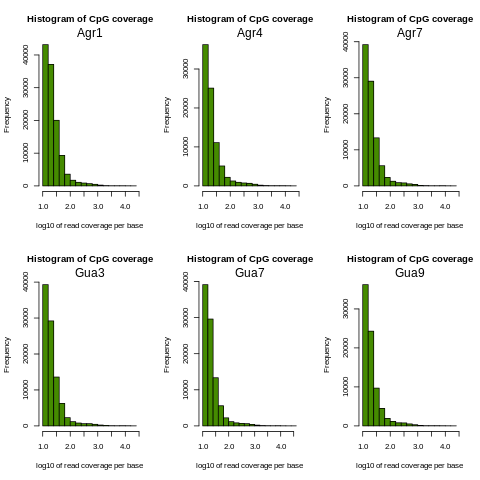

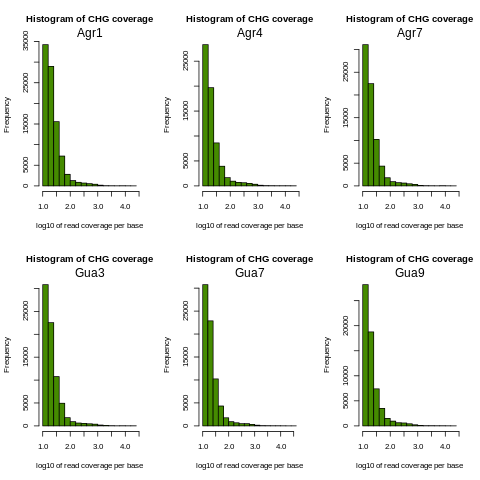

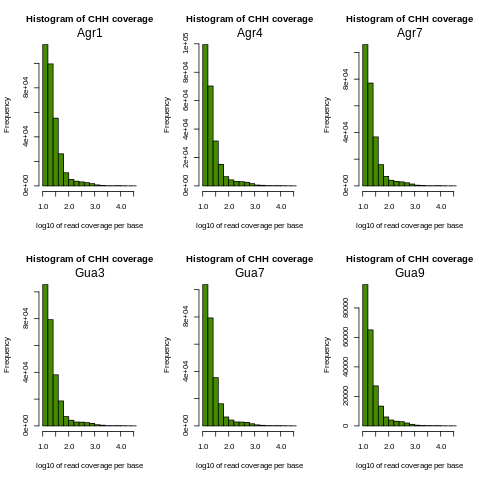

In [ ]:
#@title Distribución de los conteos
#We can also plot the read coverage per base information in a similar way,
#again numbers on bars denote what percentage of locations are contained in that bin. 
#Experiments that are highly suffering from PCR duplication bias will have a secondary
#peak towards the right hand side of the histogram.
%%R
allContexts <- c("CpG", "CHG", "CHH")
numPlotRows <- 2 #
numPlotCols <- length(allContexts)

for (c in allContexts){
  layout(matrix(1:(numPlotRows*numPlotCols), nrow = numPlotRows, byrow = TRUE))
  for (i in 1:length(sampleNames)){
    if(c=="CpG"){
      getCoverageStats(CG.cov[[i]], plot = T, both.strands = F,labels = F) 
    }else if (c=="CHG"){
      getCoverageStats(CHG.cov[[i]], plot = T, both.strands = F, labels = F)
    }else{
      getCoverageStats(CHH.cov[[i]], plot = T, both.strands = F,labels = F) 
    }
  }
}

for (c in allContexts){
  pdf(paste0("/content/plots/",c,"_cobertura_rawData.pdf"))
  layout(matrix(1:(numPlotRows*numPlotCols), nrow = numPlotRows, byrow = TRUE))
  for (i in 1:length(sampleNames)){
    if(c=="CpG"){
      getCoverageStats(CG.cov[[i]], plot = T, both.strands = F,labels = F) 
    }else if (c=="CHG"){
      getCoverageStats(CHG.cov[[i]], plot = T, both.strands = F, labels = F)
    }else{
      getCoverageStats(CHH.cov[[i]], plot = T, both.strands = F,labels = F) 
    }
  }
  dev.off()
}


### Filtrar
 
Seleccionamos aquellas citosinas secuenciadas más de 10 veces y menos del max que están *presentes en el **80%** de las muestras*.



In [ ]:
#@title Datos filtrados.
# It might be useful to filter samples based on coverage. 
# Particularly, if our samples are suffering from PCR bias it would be useful to 
# discard bases with very high read coverage. Furthermore, we would also like to 
# discard bases that have low read coverage, a high enough read coverage will 
#increase the power of the statistical tests. The code below filters a methylRawList 
#and discards bases that have coverage below 10X and also discards the bases that 
#have more than 99.9th percentile of coverage in each sample.

## filtra low coverage (10X) y bias de 99.9% en alguna muestra
%%R
CG.filtered=filterByCoverage(CG.cov,lo.count=10,lo.perc=NULL,
                                          hi.count=NULL,hi.perc=99.9)
CHG.filtered=filterByCoverage(CHG.cov,lo.count=10,lo.perc=NULL,
                                          hi.count=NULL,hi.perc=99.9)
CHH.filtered=filterByCoverage(CHH.cov,lo.count=10,lo.perc=NULL,
                                          hi.count=NULL,hi.perc=99.9)

## normalization step
## These two functions will help reduce the bias in the statistical tests that 
## might occur due to systematic over-sampling of reads in certain samples.
# bajará el coverage ? si lo hace, disminuye el error tipo 1
#CG.norm <- unite(normalizeCoverage(CG.filtered))
#CHG.norm <- unite(normalizeCoverage(CHG.filtered))
#CHH.norm <- unite(normalizeCoverage(CHH.filtered))

CG.norm <- normalizeCoverage(CG.filtered)
CHG.norm <- normalizeCoverage(CHG.filtered)
CHH.norm <- normalizeCoverage(CHH.filtered)

### Distribución de los conteos
#We can also plot the read coverage per base information in a similar way,
#again numbers on bars denote what percentage of locations are contained in that bin. 
#Experiments that are highly suffering from PCR duplication bias will have a secondary
#peak towards the right hand side of the histogram.

allContexts <- c("CpG", "CHG", "CHH")
numPlotRows <- 2 #
numPlotCols <- length(allContexts)

for (c in allContexts){
  pdf(paste0("/content/plots/",c,"_cobertura_filteredData.pdf"))
  layout(matrix(1:(numPlotRows*numPlotCols), nrow = numPlotRows, byrow = TRUE))
  for (i in 1:length(sampleNames)){
    if(c=="CpG"){
      getCoverageStats(CG.norm[[i]], plot = T, both.strands = F,labels = F) 
    }else if (c=="CHG"){
      getCoverageStats(CHG.norm[[i]], plot = T, both.strands = F, labels = F)
    }else{
      getCoverageStats(CHH.norm[[i]], plot = T, both.strands = F,labels = F) 
    }
  }
  dev.off()
}

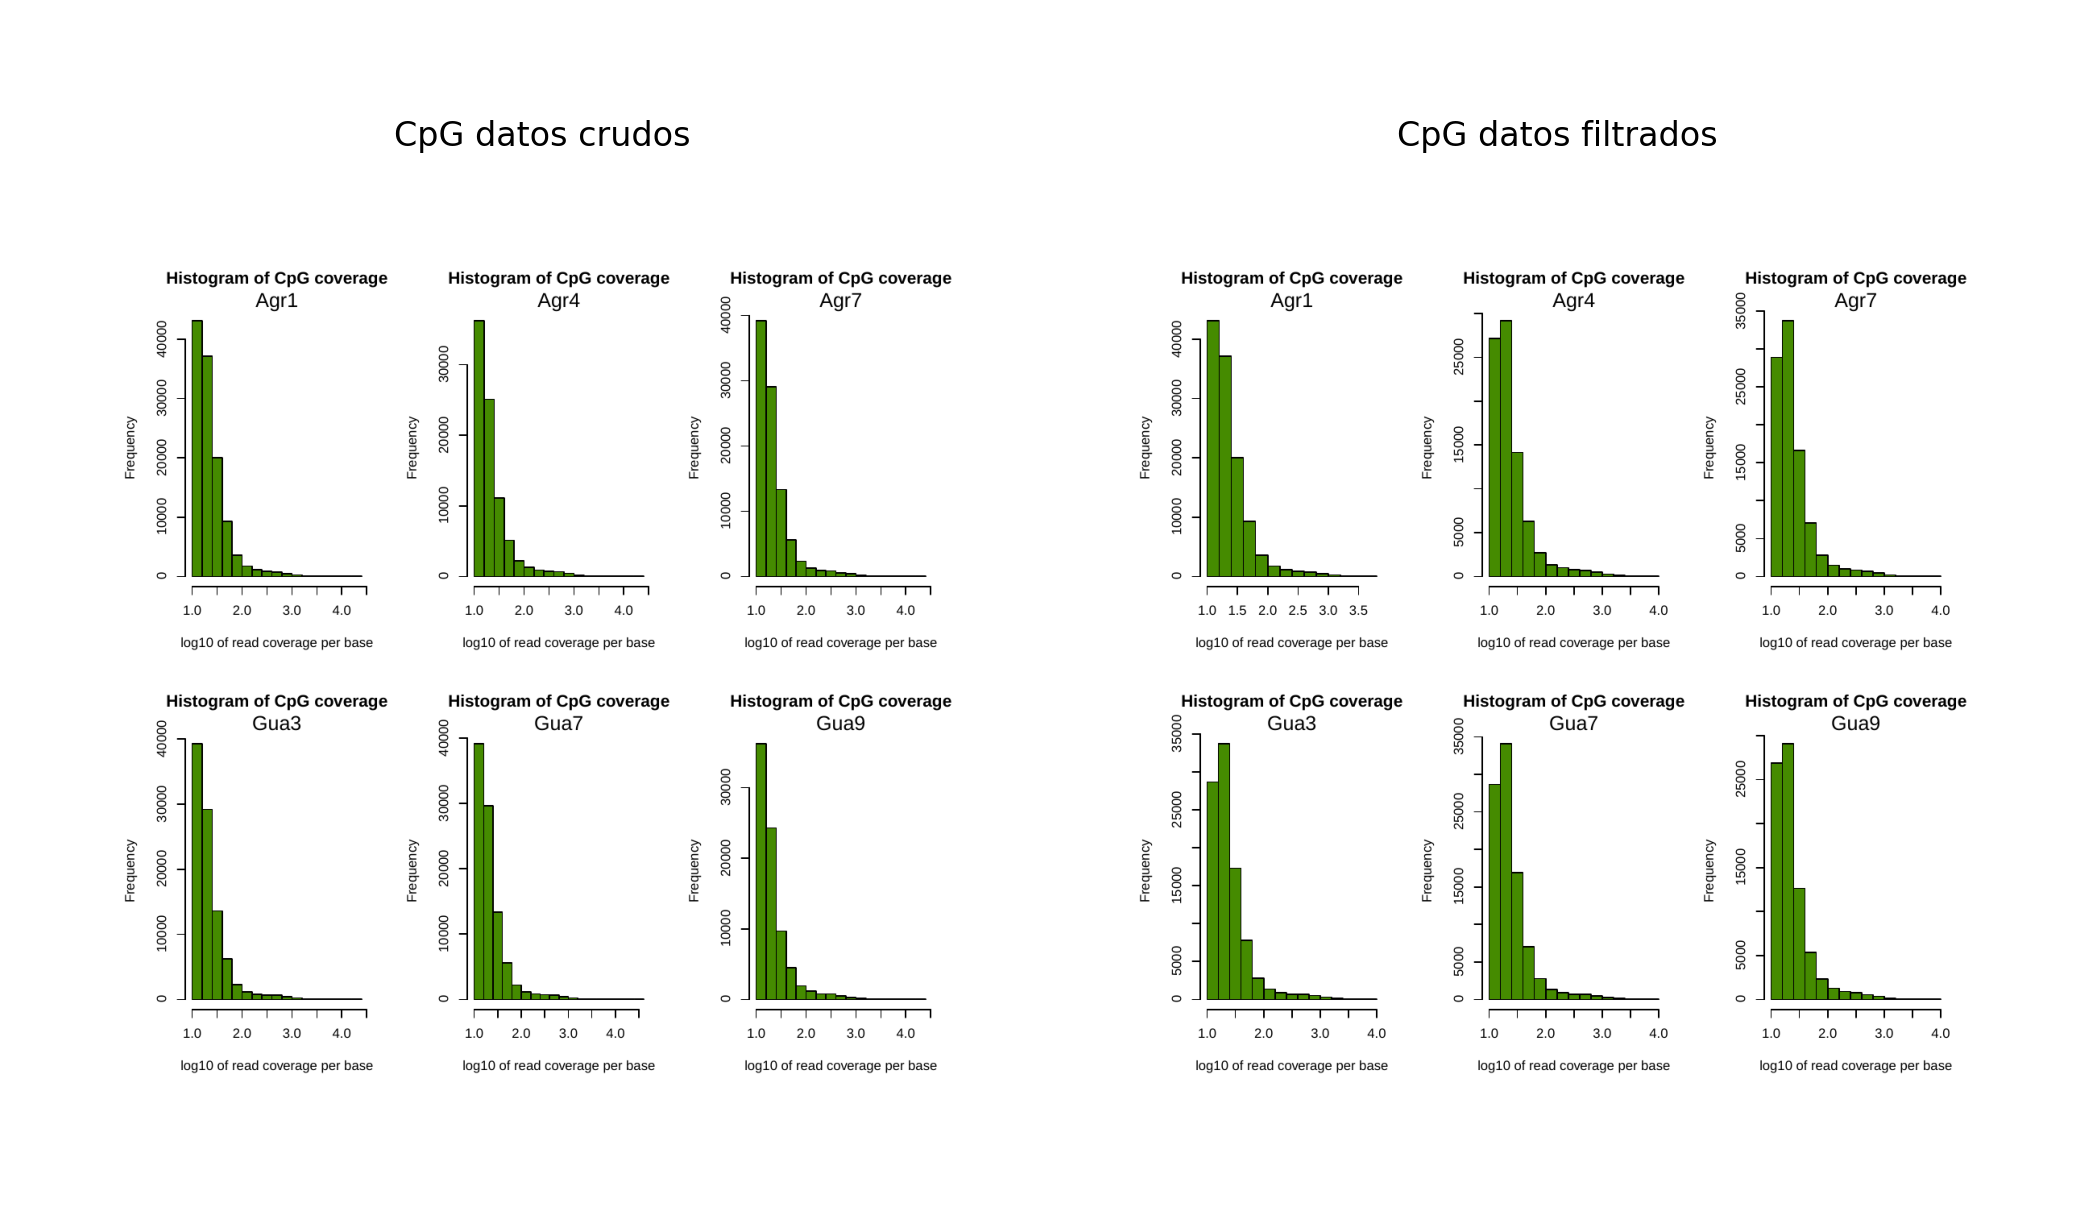

In [ ]:
#@title Comparación de la distribución del coverage
# python imports & install
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
!apt-get install poppler-utils > /dev/null
# pdf -> png
!pdftoppm /content/plots/CpG_cobertura_rawData.pdf CpG_cobertura_rawData -png
!pdftoppm /content/plots/CpG_cobertura_filteredData.pdf CpG_cobertura_filteredData -png


figs, axs = plt.subplots(1, 2, dpi=1200, figsize=(2,2))

after_img  = mpimg.imread('CpG_cobertura_rawData-1.png')
before_img = mpimg.imread('CpG_cobertura_filteredData-1.png')

axs[0].imshow(after_img)
axs[0].axis('off')
axs[0].title.set_size(2)
axs[0].title.set_text('CpG datos crudos')

axs[1].imshow(before_img)
axs[1].axis('off')
axs[1].title.set_size(2)
axs[1].title.set_text('CpG datos filtrados')
plt.show()

<a name="step-2.5"></a>
## Diferenciación de la metilación

Se realizará un análisis de componentes principales (PCA) para visualizar la distancia entre las muestras.

R[write to console]: uniting...

R[write to console]: uniting...

R[write to console]: uniting...



png 
  2 


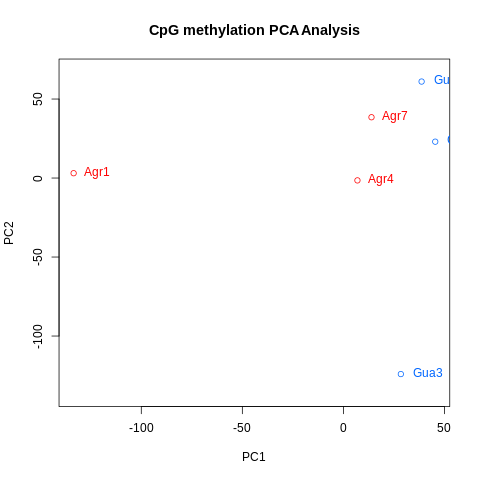

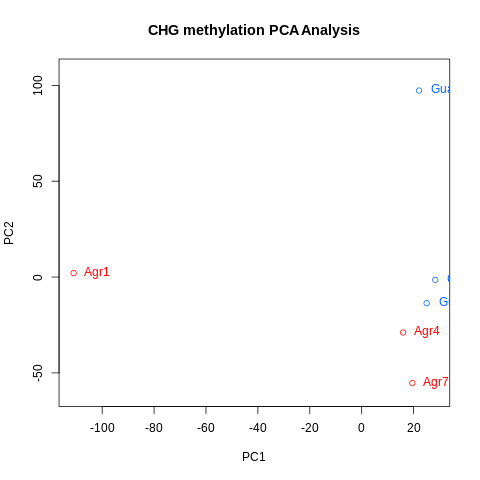

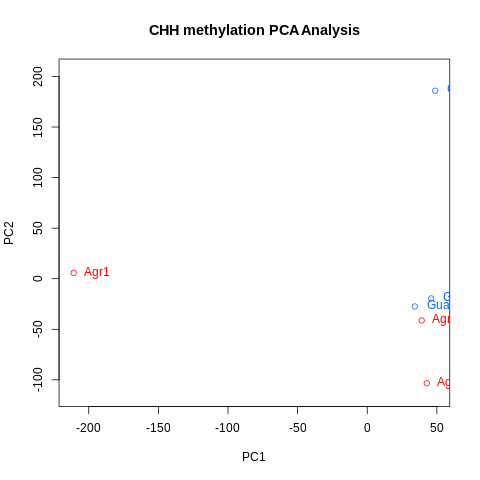

In [ ]:
#@title
%%R
#merge samples
CG.norm<-unite(CG.norm)
CHG.norm<-unite(CHG.norm)
CHH.norm<-unite(CHH.norm)
#PCA
PCASamples(CG.norm)
PCASamples(CHG.norm)
PCASamples(CHH.norm)
#save pcas
pdf(paste0("/content/plots/PCA.pdf"))
PCASamples(CG.norm)
PCASamples(CHG.norm)
PCASamples(CHH.norm)
dev.off()


<a name="step-2.6"></a>
## Cálculo de Citosinas Diferencialmente Metiladas (DMC)

Un primer análisis que interesa es conocer posiciones o citosinas diferencialmente metiladas.

In [ ]:
#@title Cálculo DMC
%%R
options(warn=-1)
CG <- data.frame(calculateDiffMeth(CG.norm))
CHG <- data.frame(calculateDiffMeth(CHG.norm))
CHH <- data.frame(calculateDiffMeth(CHH.norm))


R[write to console]: two groups detected:
 will calculate methylation difference as the difference of
treatment (group: 1) - control (group: 0)

R[write to console]: two groups detected:
 will calculate methylation difference as the difference of
treatment (group: 1) - control (group: 0)

R[write to console]: two groups detected:
 will calculate methylation difference as the difference of
treatment (group: 1) - control (group: 0)



In [ ]:
%%R
#@title (ejecutar)
cat("\t\t Vista previa de la tabla para CG:\n\n")
head(CG)

		 Vista previa de la tabla para CG:

  chr start   end strand      pvalue    qvalue meth.diff
1   1 32082 32082      - 0.006443168 0.1093278 -7.272727
2   1 32084 32084      - 1.000000000 0.8986426  0.000000
3   1 32124 32124      - 0.039769457 0.2730475  4.938272
4   1 32528 32528      + 1.000000000 0.8986426  0.000000
5   1 32569 32569      + 1.000000000 0.8986426  0.000000
6   1 32685 32685      - 0.110159668 0.4301661  2.620990


## Cálculo de Regiones Diferencialmente Metiladas (DMR)

Un segundo análisis que interesa es conocer regiones o grupos de citosinas diferencialmente metiladas. En este caso, se define una ventana de nucleótidos para que sean analizados.



In [ ]:
#@title Cálculo DMR
## Hace el methylation calling en bins (o tiles) en lugar de por base para cada (se puede variar el win size)
%%R
options(warn=-1)
CG.wind <- tileMethylCounts(CG.norm, win.size = 100, step.size = 100)
CHG.wind <- tileMethylCounts(CHG.norm, win.size = 100, step.size = 100)
CHH.wind <- tileMethylCounts(CHH.norm, win.size = 100, step.size = 100)

CG.bins <- data.frame(calculateDiffMeth(CG.wind))
CHG.bins <- data.frame(calculateDiffMeth(CHG.wind))
CHH.bins <- data.frame(calculateDiffMeth(CHH.wind))

CG.bins$chr<-as.numeric(CG.bins$chr)
CHG.bins$chr<-as.numeric(CHG.bins$chr)
CHH.bins$chr<-as.numeric(CHH.bins$chr)


R[write to console]: two groups detected:
 will calculate methylation difference as the difference of
treatment (group: 1) - control (group: 0)

R[write to console]: two groups detected:
 will calculate methylation difference as the difference of
treatment (group: 1) - control (group: 0)

R[write to console]: two groups detected:
 will calculate methylation difference as the difference of
treatment (group: 1) - control (group: 0)



In [ ]:
%%R
#@title (ejecutar)
cat("\t\t Vista previa de la tabla para CG:\n\n")
head(CG.bins)

		 Vista previa de la tabla para CG:

  chr start   end strand      pvalue     qvalue  meth.diff
1   1 32001 32100      * 0.006778627 0.05542051 -3.6363636
2   1 32101 32200      * 0.039769457 0.14677586  4.9382716
3   1 32501 32600      * 1.000000000 0.80029861  0.0000000
4   1 32601 32700      * 0.110159668 0.25763509  2.6209901
5   1 58001 58100      * 0.499441707 0.64476048 -0.7864267
6   1 58101 58200      * 0.515770659 0.65899845 -0.2578489


In [ ]:
%%R
#@title Explorar resultados
#CG context
CG.DMC<-subset(CG, CG$qvalue<0.05)
CG.DMR<-subset(CG.bins, CG.bins$qvalue<0.05)
#CHG context
CHG.DMC<-subset(CHG, CHG$qvalue<0.05)
CHG.DMR<-subset(CHG.bins, CHG.bins$qvalue<0.05)
#
CHH.DMC<-subset(CHH, CHH$qvalue<0.05)
CHH.DMR<-subset(CHH.bins, CHH.bins$qvalue<0.05)
#
cat("Citosinas diferencialmente metiladas en CG:\n")
cat("Por posición (DMC) = ",nrow(CG.DMC),"\n")
cat("Por región   (DMR) = ",nrow(CG.DMR),"\n")
cat("----------------------------------------------\n")
cat("Citosinas diferencialmente metiladas en CHG:\n")
cat("Por posición (DMC) = ",nrow(CHG.DMC),"\n")
cat("Por región   (DMR) = ",nrow(CHG.DMR),"\n")
cat("----------------------------------------------\n")
cat("Citosinas diferencialmente metiladas en CHG:\n")
cat("Por posición (DMC) = ",nrow(CHH.DMC),"\n")
cat("Por región   (DMR) = ",nrow(CHH.DMR),"\n")

Citosinas diferencialmente metiladas en CG:
Por posición (DMC) =  1194 
Por región   (DMR) =  1458 
----------------------------------------------
Citosinas diferencialmente metiladas en CHG:
Por posición (DMC) =  122 
Por región   (DMR) =  262 
----------------------------------------------
Citosinas diferencialmente metiladas en CHG:
Por posición (DMC) =  281 
Por región   (DMR) =  1013 


In [ ]:
%%R
#@title save
#CG
cg<-CG.DMC
colnames(cg)<-NULL
rownames(cg)<-NULL
cg<-cg[,1:3]
write.csv(cg, "CG.DMC.csv", sep="\t",col.names=FALSE, row.names=FALSE)
#CHG
chg<-CHG.DMC
colnames(chg)<-NULL
rownames(chg)<-NULL
chg<-chg[,1:3]
write.csv(chg, "CHG.DMC.csv", sep="\t",col.names=FALSE, row.names=FALSE)
#CHH
chh<-CHH.DMC
colnames(chh)<-NULL
rownames(chh)<-NULL
chh<-chh[,1:3]
write.csv(chh, "CHH.DMC.csv", sep="\t",col.names=FALSE, row.names=FALSE)

###DMR
#CG
cg<-CG.DMR
colnames(cg)<-NULL
rownames(cg)<-NULL
cg<-cg[,1:3]
write.csv(cg, "CG.DMR.csv", sep="\t",col.names=FALSE, row.names=FALSE)
#CHG
chg<-CHG.DMR
colnames(chg)<-NULL
rownames(chg)<-NULL
chg<-chg[,1:3]
write.csv(chg, "CHG.DMR.csv", sep="\t",col.names=FALSE, row.names=FALSE)
#CHH
chh<-CHH.DMR
colnames(chh)<-NULL
rownames(chh)<-NULL
chh<-chh[,1:3]
write.csv(chh, "CHH.DMR.csv", sep="\t",col.names=FALSE, row.names=FALSE)


In [ ]:
%%R
#@title Anotación para DMC y DMR
inFileAnnotation<-("/content/rawData/annotation.csv")
annotation<-read.table(inFileAnnotation, sep="\t", header=FALSE)
anno<-annotation[,c(1,4,5,9,10)]
colnames(anno)<-NULL
rownames(anno)<-NULL
write.csv(anno, "anno.csv", sep="\t",col.names=FALSE, row.names=FALSE)
cat("\t\t Vista previa de la tabla:\n\n")
head(annotation)

		 Vista previa de la tabla:

  V1   V2  V3      V4      V5      V6 V7 V8  V9               V10
1 14 Gaze CDS 2596280 2596420  5.6000  -  0 CDS GSVIVT01000001001
2 14 Gaze CDS 2596583 2596680 13.0034  -  2 CDS GSVIVT01000001001
3 14 Gaze CDS 2598345 2598385  5.7825  -  1 CDS GSVIVT01000001001
4 14 Gaze CDS 2598698 2598768  3.1301  -  0 CDS GSVIVT01000001001
5 14 Gaze CDS 2600666 2600989 12.2000  -  0 CDS GSVIVT01000002001
6 14 Gaze CDS 2601271 2601354 15.0000  -  0 CDS GSVIVT01000002001


### Usar bedtool para la interseccion

Utilizaremos la herramienta [bedtools](https://bedtools.readthedocs.io/en/latest/index.html) para la identificar el solapamiento de las coordenadas ( chr, start - end) de las DMC o DMR y las coordenadas de los genes y promotores.

Por ejemplo, la siguiente figura esquematiza la posición y tamaño de genes (azul) que está alineado con la posición y tamaño de DMRs (naranja). 

Bedtools va a informar las coordenadas de las regiones que se solapan (verde).
<p align="left">
<img src="https://raw.githubusercontent.com/VeronicaNoe/EpiEvo/main/img/3/bedtoolsTutorial.png" width="800"/> 
</p>



In [ ]:
#@title en bash
#transform csv into bed files
#CG
!cat CG.DMC.csv | tr ',' '\t' > CG.DMC.bed
#CHG
!cat CHG.DMC.csv | tr ',' '\t' > CHG.DMC.bed
#CHH
!cat CHH.DMC.csv | tr ',' '\t' > CHH.DMC.bed

#CG
!cat CG.DMR.csv | tr ',' '\t' > CG.DMR.bed
#CHG
!cat CHG.DMR.csv | tr ',' '\t' > CHG.DMR.bed
#CHH
!cat CHH.DMR.csv | tr ',' '\t' > CHH.DMR.bed

#annotation
!cat anno.csv | tr ',' '\t' | sed 's/"//g' > anno.bed

## install bedtools
!sudo apt-get install bedtools > /dev/null
!bedtools intersect -a CG.DMC.bed -b anno.bed -wa -wb > CG_DMC_intersect_anno.tsv
!bedtools intersect -a CHG.DMC.bed -b anno.bed -wa -wb > CHG_DMC_intersect_anno.tsv
!bedtools intersect -a CHH.DMC.bed -b anno.bed -wa -wb > CHH_DMC_intersect_anno.tsv

!bedtools intersect -a CG.DMR.bed -b anno.bed -wa -wb > CG_DMR_intersect_anno.tsv
!bedtools intersect -a CHG.DMR.bed -b anno.bed -wa -wb > CHG_DMR_intersect_anno.tsv
!bedtools intersect -a CHH.DMR.bed -b anno.bed -wa -wb > CHH_DMR_intersect_anno.tsv


debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


In [ ]:
%%R
#@title 
interFiles<-list.files(pattern = "_intersect_anno.tsv")
length(interFiles)
out<-c()
#unite all files
for (i in 1:length(interFiles)){
    temp<-read.table(interFiles[i], sep="\t")
    temp.1<-unlist(strsplit(interFiles[i], "_"))[1]
    ctxt<-rep(temp.1, times=nrow(temp))
    temp.2<-unlist(strsplit(interFiles[i], "_"))[2]
    dm<-rep(temp.2, times=nrow(temp))
    temp.3<-cbind(temp[,1:7],ctxt, dm)
    out<-rbind(out,temp.3)
}
colnames(out)<-c("chr", "start", "end","chr_Annotation", "start_Annotation", "end_Annotation", "feature", "context", "DM")

#summarize number of differentialy methylated C's by position (DMC) or by region (DMR)

DM<-unique(out$DM)
ctxt<-unique(out$context)
ftre<-unique(out$feature)

summaryDF<-c()

for(d in 1:length(DM)){
    for (c in 1:length(ctxt)){
        for(f in 1:length(ftre)){
            temp<-subset(out, c(out$DM==DM[d] & out$context==ctxt[c] & out$feature==ftre[f]))
            totalDM<-nrow(temp)
            temp.1<-cbind(DM[d],ctxt[c],ftre[f], totalDM)
            summaryDF<-rbind(summaryDF,temp.1)
        }
    }
}
colnames(summaryDF)<-c("DM", "context", "feature","number_DM")
summaryDF<-data.frame(summaryDF)
summaryDF$number_DM<-as.numeric(summaryDF$number_DM)
summaryDF


    DM context  feature number_DM
1  DMC      CG      CDS       263
2  DMC      CG promoter         2
3  DMC     CHG      CDS        19
4  DMC     CHG promoter         0
5  DMC     CHH      CDS        33
6  DMC     CHH promoter         2
7  DMR      CG      CDS       263
8  DMR      CG promoter         2
9  DMR     CHG      CDS        19
10 DMR     CHG promoter         0
11 DMR     CHH      CDS        33
12 DMR     CHH promoter         2


In [ ]:
%%R
#@title 
library("ggplot2")

for (c in ctxt){
    temp<-subset(summaryDF, summaryDF$context==c)
    p<- ggplot(temp,aes(x=DM,y=number_DM, fill=feature)) +
       geom_bar(stat="identity", position=position_dodge()) +
       scale_y_continuous(limits = c(0, 300)) +
       labs(title=paste0(c), x="", y = "Número de DMC/feature")+ theme_bw()   
    ggsave(p,filename=paste0(c,"_summary.pdf"))
}


R[write to console]: Saving 6.67 x 6.67 in image

R[write to console]: Saving 6.67 x 6.67 in image

R[write to console]: Saving 6.67 x 6.67 in image



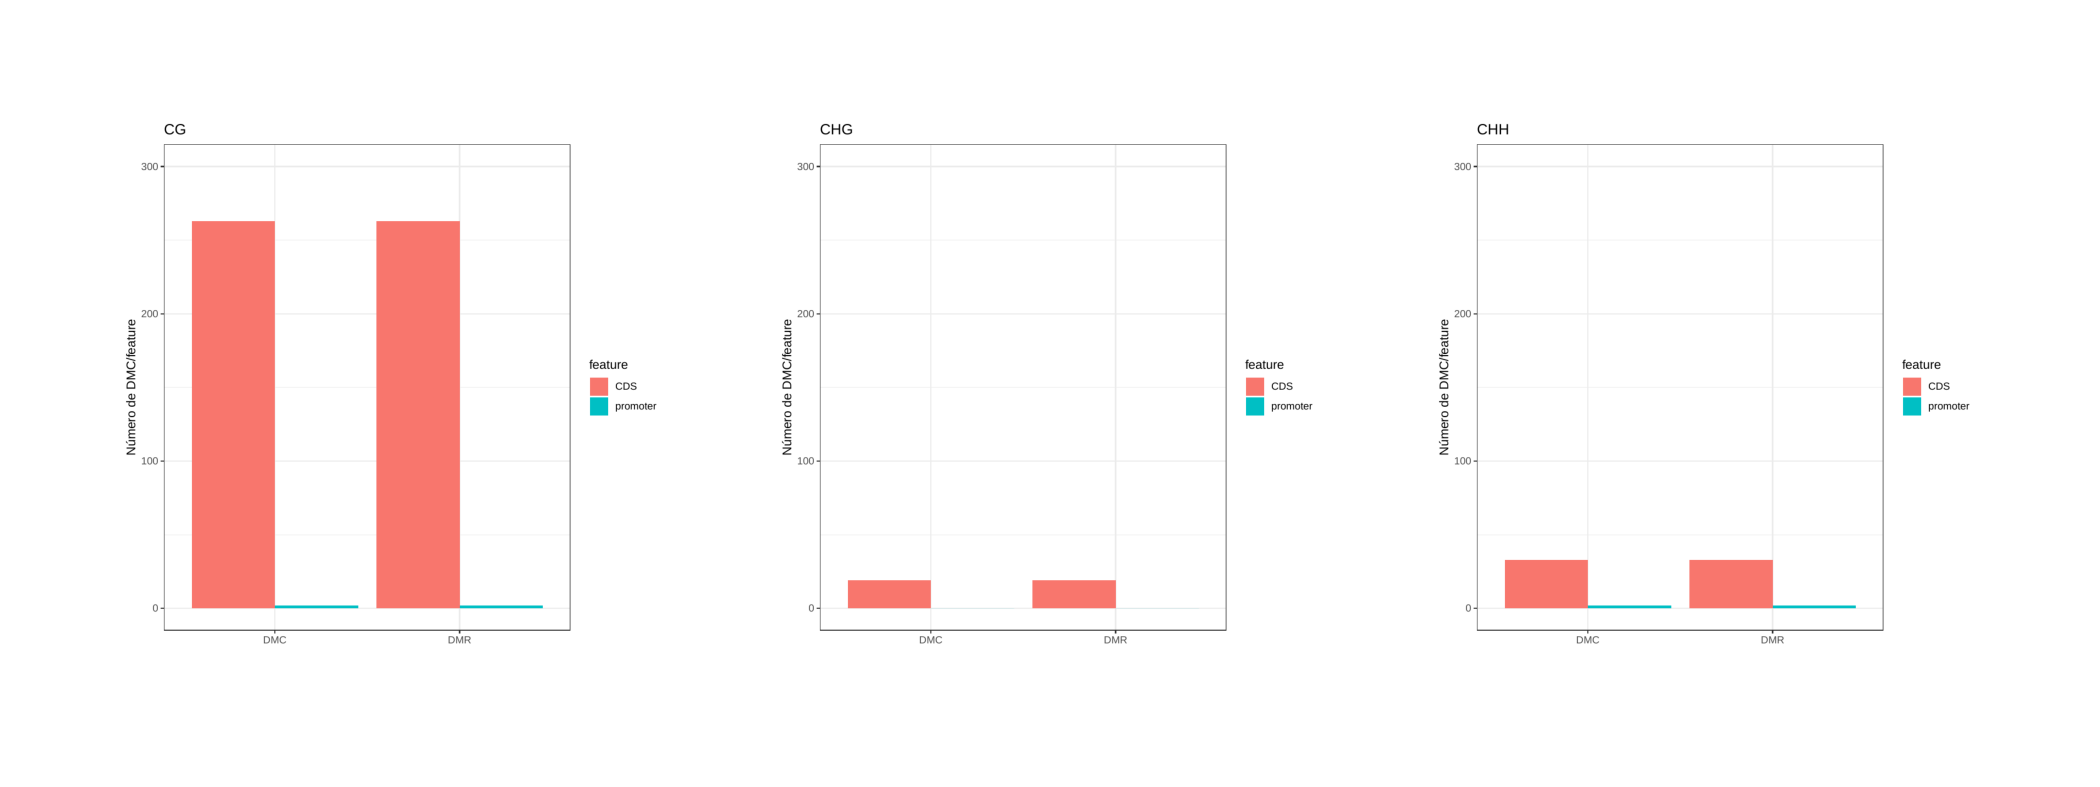

In [ ]:
#@title Comparación de la distribución del coverage
# python imports & install
# pdf -> png
!pdftoppm CG_summary.pdf CG_summary -png
!pdftoppm CHG_summary.pdf CHG_summary -png
!pdftoppm CHH_summary.pdf CHH_summary -png

figs, axs = plt.subplots(1,3, dpi=1200, figsize=(2,2))

after_img  = mpimg.imread('CG_summary-1.png')
midle_img  = mpimg.imread('CHG_summary-1.png')
before_img = mpimg.imread('CHH_summary-1.png')

axs[0].imshow(after_img)
axs[0].axis('off')

axs[1].imshow(midle_img)
axs[1].axis('off')

axs[2].imshow(before_img)
axs[2].axis('off')
plt.show()


<a name="step-3"></a>
# OPCIONAL: Guardar en Drive

Opcional. 
Depende del espacio disponible en Drive.
Si desea copiar los datos, debe eliminar el numeral (`#`) de cada línea de código EXCEPTO la primera ``#@title``

In [ ]:
#@title Guardar archivos en el Drive personal
%%bash
#mkdir ../drive/MyDrive/EpiEvo/TP_3
#cd ..
#ls
#cp -r {plots,rawData,results} drive/MyDrive/EpiEvo/TP_3/
#ls ../drive/MyDrive/EpiEvo/TP_3